In [1]:
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn import metrics
from sklearn.linear_model import LogisticRegression as LogReg, LinearRegression as LinReg

from sklearn.metrics import accuracy_score as accuracy, recall_score as recall, precision_score as precision, f1_score as f1, confusion_matrix

## Import Logistic Regression from  sklearn

from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor # a module to evaluate the variance inflation factor (VIF)

from time import time

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier  ### Decision tree classifications!
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Cleaning and Feature Engineering function

#### Some things we can feature engineer:
* One hot encoding all categorical values OR changing ALL no's into 0s
* Null handling

In [2]:
df = pd.read_excel('customer_churn.xlsx')

In [3]:
#### Create our Data cleaning Function

def clean_data(df):

    ## DROPPING COLUMNS:
    drop = ['Count', 'CustomerID', 'Country', 'City', 'State', 'Lat Long', 'Churn Label', 'Churn Reason']
    df.drop(columns = df[drop], inplace = True)

    ## TOTAL CHARGES:
    ## Convert Data Type Total Charges str to float ##
    df['Total Charges'] = pd.to_numeric(df['Total Charges'],errors='coerce')
    #### Drop Nulls from Total Charges ####
    df = df.dropna(axis=0, subset=['Total Charges'])


    ## CONVERTING COLUMNS INTO BOOLS:
    bools = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing' ]
    for x in bools:
        df[x] = df[x].map({'No': 0, 'Yes':1})
    ## Convert Gender column into Bools ##
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

    df_clean = df.copy()

    return df_clean


In [4]:
#### Create our Feature Engineering Function for regression

def feature_eng_regression(df):

    df_eng = df.copy()
    #### Set our y Values ####

    target = df_eng['Churn Value']

    #### Drop the y column (Churn Value) ####

    df_eng.drop(columns = 'Churn Value', inplace=True)

    #ONE HOT ENCODING:

    eng_columns = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup',
                   'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
                   'Contract', 'Payment Method']

    df_eng = pd.get_dummies(df_eng, columns = eng_columns, drop_first=True)

    ### Log features ###

    df_eng['Log Tenure Months'] = np.log(df_eng['Tenure Months'])

    return df_eng, target


In [5]:
df_clean = clean_data(df.copy())

#### Define functions for Accuracy / Precision / Recall / F1

In [6]:
## function to calc and print accuracy, precision, recall and f1 score
def apr(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)

    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

# Function to produce a confusion matrix
def produce_confusion(positive_label, negative_label, cut_off, df, y_pred_name, y_real_name):

    #Set pred to 0 or 1 depending on whether it's higher than the cut_off point.

    if cut_off != 'binary':
        df['pred_binary'] = np.where(df[y_pred_name] > cut_off , 1, 0)
    else:
        df['pred_binary'] = df[y_pred_name]

    #Build the matrix
    cm = confusion_matrix(df[y_real_name], df['pred_binary'])
    # plot confusion matrix
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g');

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    print('Test accuracy = ', metrics.accuracy_score(df[y_real_name], df['pred_binary']))

    return metrics.accuracy_score(df[y_real_name], df['pred_binary'])


# Logistic Regression Modelling

#### Applying feature engineering function and Test Train Split

In [7]:
df_eng, target = feature_eng_regression(df_clean)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_eng, target, test_size = 0.2, random_state = 42)

In [9]:
X_train

,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Log Tenure Months
6030,93307,35.280113,-118.962329,0,0,1,0,24,1,1,...,0,1,0,1,0,0,0,1,0,3.178054
3409,92328,36.276880,-117.033326,1,0,1,0,40,1,1,...,0,0,0,0,0,0,1,0,0,3.688879
5482,96062,40.531257,-122.148139,0,0,1,0,4,1,0,...,0,1,0,0,0,0,0,1,0,1.386294
5523,96141,39.117018,-120.212535,1,0,0,0,4,1,0,...,0,1,0,0,0,0,1,0,0,1.386294
6337,95120,37.186141,-121.843554,1,0,1,1,64,1,0,...,1,0,1,0,1,0,0,0,1,4.158883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3777,94132,37.722302,-122.491129,1,1,0,1,30,1,1,...,0,1,0,1,0,0,0,1,0,3.401197
5199,95346,38.121601,-120.133915,1,1,0,0,70,1,1,...,0,1,0,0,0,1,0,0,0,4.248495
5234,95439,38.493888,-122.777141,0,0,0,0,34,1,1,...,0,1,0,1,0,0,0,1,0,3.526361
5398,95910,39.467828,-120.841386,0,0,0,0,9,1,0,...,0,0,0,0,0,0,0,0,1,2.197225


In [10]:
X_test

,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Log Tenure Months
2478,93643,37.244307,-119.470256,1,0,1,0,42,1,0,...,1,0,1,0,0,1,0,1,0,3.737670
6783,90247,33.890853,-118.297967,0,0,0,0,43,0,0,...,0,0,0,1,1,0,0,1,0,3.761200
6125,93660,36.600193,-120.153393,1,0,0,0,27,1,1,...,0,0,0,1,0,0,0,1,0,3.295837
3052,96090,40.021787,-122.127576,0,0,0,0,65,1,1,...,1,0,1,0,0,1,1,0,0,4.174387
4097,95619,38.683605,-120.811852,1,0,0,0,29,1,1,...,0,1,0,1,1,0,1,0,0,3.367296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,96052,40.704293,-122.803899,0,0,0,0,35,1,1,...,0,1,0,1,1,0,0,0,0,3.555348
5249,95458,39.141934,-122.770679,1,0,1,0,71,1,0,...,0,1,0,1,0,1,0,1,0,4.262680
5464,96033,40.740138,-122.587476,0,0,0,0,16,1,1,...,0,0,0,0,0,0,0,0,1,2.772589
5851,92325,34.248061,-117.290280,0,0,0,0,31,1,0,...,1,0,1,0,0,1,0,0,1,3.433987


In [11]:
### Edit features for model here

mod_cols = [ 'Gender', 'Senior Citizen',
             'Partner', 'Dependents',
             'Paperless Billing', 'Multiple Lines_No phone service', 'Internet Service_Fiber optic',
             'Online Security_Yes', 'Log Tenure Months',
             'Online Backup_Yes',
             'Tech Support_Yes',
             'Streaming TV_Yes',
             'Payment Method_Credit card (automatic)',
             'Payment Method_Electronic check', 'Payment Method_Mailed check']

X_train = X_train[mod_cols]

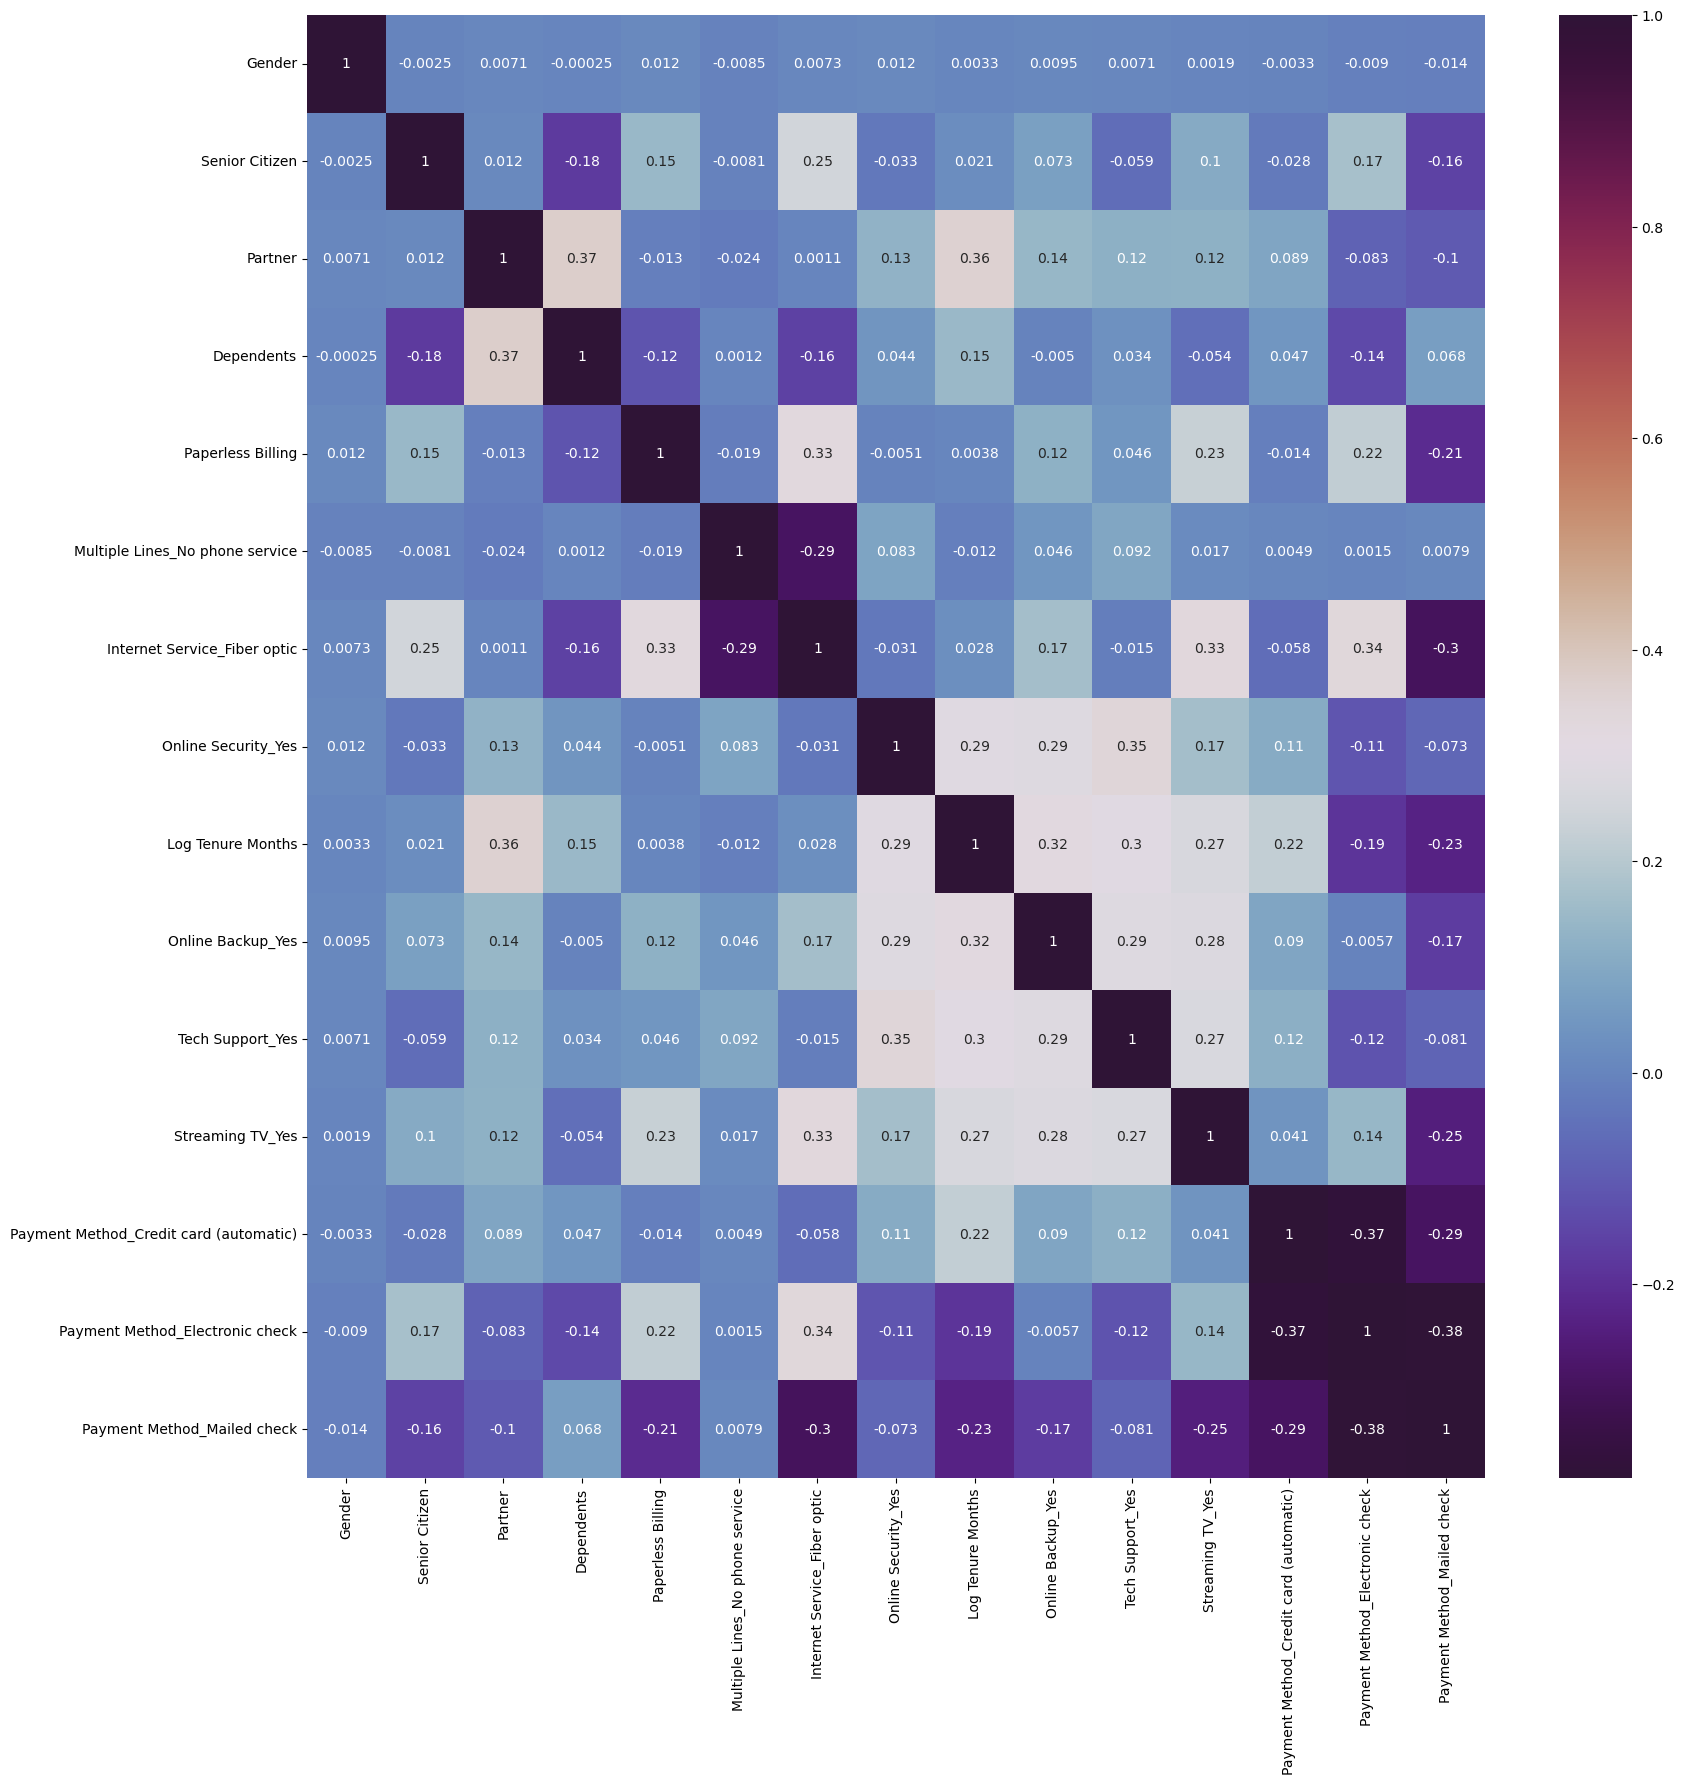

In [12]:
## See a heatmap of the correlations
plt.figure(figsize = (19,19))
sns.heatmap(X_train.corr(),
            annot = True,
            cmap = "twilight_shifted")
plt.show()

In [13]:
### Check for inflation factors

# from statsmodels.stats.outliers_influence import variance_inflation_factor

def checkVIF(X):
    vif = pd.DataFrame() # make empty df
    vif['Features'] = mod_cols # features used in training

    #calc vif for each feature using function imported w statsmodels
    vif['VIF'] = [variance_inflation_factor(X[mod_cols].values, i) for i in range(X[mod_cols].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2) #rounding 2 d.p
    vif = vif.sort_values(by = "VIF", ascending = False) # sort highest to lowest multicollinairty.
    return(vif)

checkVIF(X_train)

,Features,VIF
8,Log Tenure Months,5.58
6,Internet Service_Fiber optic,2.71
4,Paperless Billing,2.69
2,Partner,2.55
11,Streaming TV_Yes,2.18
13,Payment Method_Electronic check,2.13
9,Online Backup_Yes,1.94
0,Gender,1.84
10,Tech Support_Yes,1.82
7,Online Security_Yes,1.73


In [14]:
### Fit the logistic regression on the TRAINING data not the testing data

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [15]:
### Create columns on training data based on logistic regression model trained with training data

X_train[['prob_stay', 'prob_churned']] = lr.predict_proba(X_train)

In [16]:
### Returns confusion matrix for the logistic regression and other metrics

def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(confusion_matrix(predicted, actual), "\n")
    print(f"The accuracy of your model is: {accuracy(predicted,actual)}')")
    print(f"The recall of your model is: {recall(predicted,actual)}')")
    print(f"The precision of your model is: {precision(predicted,actual)}')")
    print(f"The F1 score of your model is: {f1(predicted,actual)}')")

In [17]:
### Metrics for TRAINING DATA

X_train['y_pred'] = np.where(X_train['prob_churned'] > 0.49, 1, 0)

get_results(y_train, X_train['y_pred'])

The confusion matrix for your predictions is:
[[3803  733]
 [ 348  741]] 

The accuracy of your model is: 0.8078222222222222')
The recall of your model is: 0.6804407713498623')
The precision of your model is: 0.5027137042062415')
The F1 score of your model is: 0.5782286383144751')


In [18]:
### Metrics for TESTING DATA

X_test = X_test[mod_cols]

X_test[['prob_stay', 'prob_churned']] = lr.predict_proba(X_test)

X_test['y_pred'] = np.where(X_test['prob_churned'] > 0.49, 1, 0)

get_results(y_test, X_test['y_pred'])

The confusion matrix for your predictions is:
[[940 191]
 [ 72 204]] 

The accuracy of your model is: 0.8130774697938877')
The recall of your model is: 0.7391304347826086')
The precision of your model is: 0.5164556962025316')
The F1 score of your model is: 0.6080476900149032')


#### Checking the importance of the Coefficients

In [19]:
coeffs = lr.coef_
coeffs = coeffs.tolist()

# coeffs = coeffs.values

coeffs
coef_list = list(zip(coeffs[0], mod_cols))
coef_list = pd.DataFrame(coef_list)
coef_list = coef_list.rename(columns = {0:'coefficient',1:'feature'})
coef_list = coef_list.sort_values(by = 'coefficient', ascending = False)
coef_list = coef_list.reset_index()



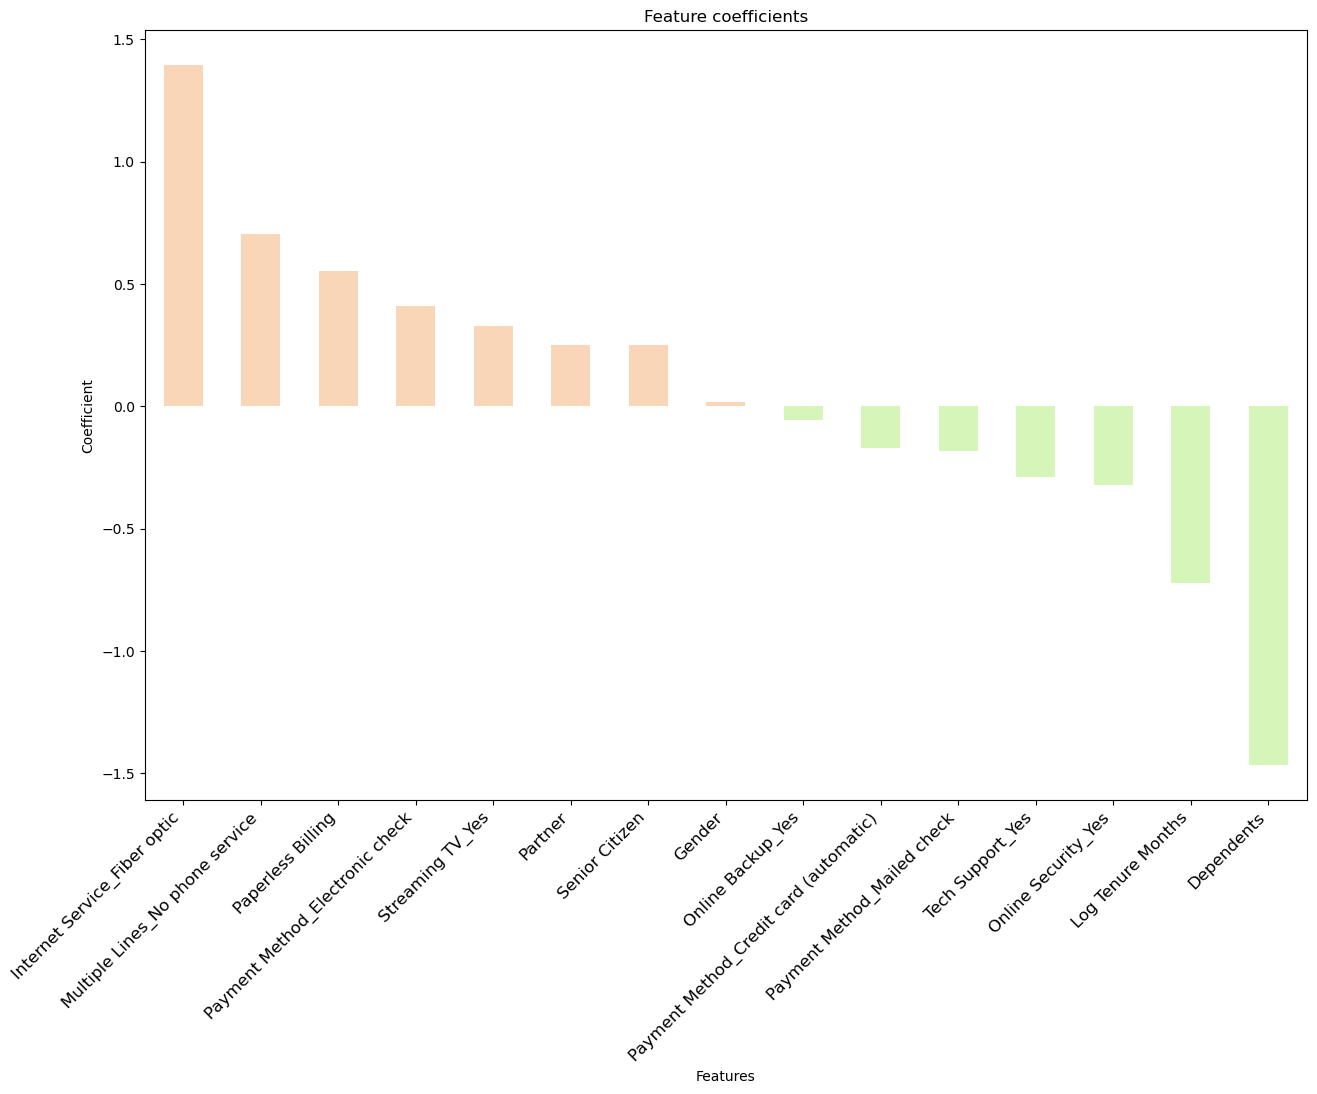

In [20]:
plt.figure(figsize=(15,10))

coef_list['positive'] = coef_list['coefficient'] > 0

bar = coef_list['coefficient'].plot(kind='bar',
                                    color=coef_list.positive.map({True: '#F9D6B8', False: '#D5F6B8'}))

bar.set(xlabel ="Features", ylabel = "Coefficient", title ='Feature coefficients')


ax1 = plt.subplot()
ax1.set_xticklabels(coef_list['feature'])

plt.xticks(rotation= 45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 12 #'large' # setting the fonts
           )


plt.show()
## Positive coefficients indicate factors increasing P(churn)
## Negative coefficients indicate factors decreasing P(churn)

# Decision Tree Model

In [21]:
#### Create our Feature Engineering Function for the decision tree modelling
## - Same as log reg feature engineering function - without dropping first col whe one hot encoding
def feature_eng_tree(df):

    df_eng = df.copy()

    target = df_eng['Churn Value']

    df_eng.drop(columns = 'Churn Value', inplace=True)

    #ONE HOT ENCODING:

    eng_columns = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup',
                   'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
                   'Contract', 'Payment Method']

    df_eng = pd.get_dummies(df_eng, columns = eng_columns, drop_first=False)

    ### Log features ###

    df_eng['Log Tenure Months'] = np.log(df_eng['Tenure Months'])

    return df_eng, target

In [22]:
df_eng, target = feature_eng_tree(df_clean)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_eng, target, test_size = 0.2, random_state = 42)

In [24]:
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [25]:
#accuracy of our test and train models
print(f'Score on training set: {treeclf.score(X_train, y_train)}')
print(f'Score on testing set: {treeclf.score(X_test, y_test)}')

Score on training set: 0.7900444444444444
Score on testing set: 0.7860696517412935


In [26]:
# Model Selection
grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [3, 4, 5, 6, 7, 8],   ## for decision trees,min 3 and max 10 are sensible for depth
                                  'min_samples_split': [3, 5, 7, 10, 13, 15],
                                  'min_samples_leaf': [4, 5, 6, 7, 8, 9, 10]},
                    cv = 5,
                    refit = True,
                    verbose = 1,
                    scoring = 'accuracy')

In [27]:
# Running a tree for each combination of parameters

now = time()

grid.fit(X_train, y_train)

print(f' Time in seconds: {time() - now}')

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
 Time in seconds: 24.829375505447388


In [28]:
# Params with highest score
grid.best_params_

{'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 3}

In [29]:
grid.best_score_

0.7975111111111112

In [30]:
#
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, min_samples_split=7)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, min_samples_split=7)

In [31]:
# Evaluate model.
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(X_test, y_test)}')

Score on training set: 0.8110222222222222
Score on testing set: 0.7924662402274343


In [32]:
## TRAIN Predictions
train_results = X_train.copy()
train_results['y_pred'] = dt.predict(X_train)
train_results['y_real'] = y_train
train_results['y_prob'] = dt.predict_proba(X_train)[:,1]

train_results

,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,...,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Log Tenure Months,y_pred,y_real,y_prob
6030,93307,35.280113,-118.962329,0,0,1,0,24,1,1,...,0,0,0,0,1,0,3.178054,1,0,0.576923
3409,92328,36.276880,-117.033326,1,0,1,0,40,1,1,...,0,0,0,1,0,0,3.688879,0,0,0.324895
5482,96062,40.531257,-122.148139,0,0,1,0,4,1,0,...,0,0,0,0,1,0,1.386294,0,0,0.481781
5523,96141,39.117018,-120.212535,1,0,0,0,4,1,0,...,0,0,0,1,0,0,1.386294,0,0,0.481781
6337,95120,37.186141,-121.843554,1,0,1,1,64,1,0,...,1,0,0,0,0,1,4.158883,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3777,94132,37.722302,-122.491129,1,1,0,1,30,1,1,...,0,0,0,0,1,0,3.401197,0,0,0.000000
5199,95346,38.121601,-120.133915,1,1,0,0,70,1,1,...,0,1,1,0,0,0,4.248495,0,0,0.006424
5234,95439,38.493888,-122.777141,0,0,0,0,34,1,1,...,0,0,0,0,1,0,3.526361,1,0,0.576923
5398,95910,39.467828,-120.841386,0,0,0,0,9,1,0,...,0,0,0,0,0,1,2.197225,1,0,0.560669


In [33]:
## TEST Predictions
test_results = X_test.copy()
test_results['y_pred'] = dt.predict(X_test)
test_results['y_real'] = y_test
test_results['y_prob'] = dt.predict_proba(X_test)[:,1]

test_results

,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,...,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Log Tenure Months,y_pred,y_real,y_prob
2478,93643,37.244307,-119.470256,1,0,1,0,42,1,0,...,0,1,0,0,1,0,3.737670,0,0,0.000000
6783,90247,33.890853,-118.297967,0,0,0,0,43,0,0,...,1,0,0,0,1,0,3.761200,0,0,0.256410
6125,93660,36.600193,-120.153393,1,0,0,0,27,1,1,...,0,0,0,0,1,0,3.295837,1,0,0.576923
3052,96090,40.021787,-122.127576,0,0,0,0,65,1,1,...,0,1,0,1,0,0,4.174387,0,0,0.006424
4097,95619,38.683605,-120.811852,1,0,0,0,29,1,1,...,1,0,0,1,0,0,3.367296,0,0,0.256410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,96052,40.704293,-122.803899,0,0,0,0,35,1,1,...,1,0,1,0,0,0,3.555348,0,1,0.124224
5249,95458,39.141934,-122.770679,1,0,1,0,71,1,0,...,0,1,0,0,1,0,4.262680,0,0,0.000000
5464,96033,40.740138,-122.587476,0,0,0,0,16,1,1,...,0,0,0,0,0,1,2.772589,0,0,0.324895
5851,92325,34.248061,-117.290280,0,0,0,0,31,1,0,...,0,1,0,0,0,1,3.433987,0,0,0.006424


In [34]:
dt.feature_importances_

array([0.03010014, 0.00226021, 0.00235982, 0.        , 0.01083248,
       0.        , 0.07637914, 0.09948611, 0.00389586, 0.00434729,
       0.02826929, 0.01927211, 0.        , 0.00113171, 0.        ,
       0.        , 0.15529686, 0.        , 0.00281675, 0.        ,
       0.        , 0.0078838 , 0.        , 0.        , 0.        ,
       0.        , 0.00080066, 0.02476603, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00346308, 0.44636171, 0.        , 0.00395879, 0.        ,
       0.        , 0.01697545, 0.        , 0.0593427 ])

In [35]:
importance = list(zip(mod_cols, list(dt.feature_importances_)))

In [36]:
importance

[('Gender', 0.030100144453029724),
 ('Senior Citizen', 0.0022602144178252397),
 ('Partner', 0.002359815646235864),
 ('Dependents', 0.0),
 ('Paperless Billing', 0.010832476058438449),
 ('Multiple Lines_No phone service', 0.0),
 ('Internet Service_Fiber optic', 0.07637914497766854),
 ('Online Security_Yes', 0.09948611082276995),
 ('Log Tenure Months', 0.0038958563868036417),
 ('Online Backup_Yes', 0.004347292283984966),
 ('Tech Support_Yes', 0.028269291443491384),
 ('Streaming TV_Yes', 0.019272111146597687),
 ('Payment Method_Credit card (automatic)', 0.0),
 ('Payment Method_Electronic check', 0.001131708418030854),
 ('Payment Method_Mailed check', 0.0)]

In [37]:
churn_results = apr(test_results['y_real'], test_results['y_pred'])

Accuracy:0.7924662402274343
Precision:0.5316455696202531
Recall:0.6624605678233438
F1:0.5898876404494381


Test accuracy =  0.7924662402274343


0.7924662402274343

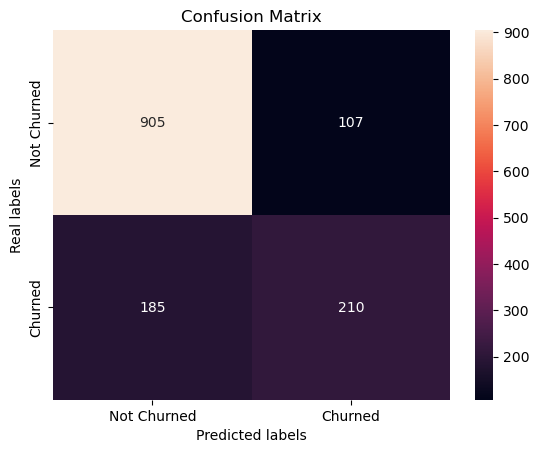

In [38]:
produce_confusion('Churned', 'Not Churned', 'binary', test_results, 'y_pred', 'y_real')


Note the descision tree is too large to visualise well in the notebook

# Random Forest Modelling

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_clean, df_clean['Churn Value'], test_size = 0.2, random_state = 42)

### Apply feature engineering to train data

X_train, y_train = feature_eng_tree(X_train)

### Apply feature engineering to test data

X_test, y_test = feature_eng_tree(X_test)

In [40]:
## use the bagging classifier

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier())


##
bag.fit(X_train, y_train)

##
bag.score(X_test, y_test)

0.7896233120113717

In [41]:
rf = RandomForestClassifier(n_estimators=50)
et = ExtraTreesClassifier(n_estimators=50)

In [42]:
rf_score = cross_val_score(rf, X_train, y_train, cv=5)
et_score = cross_val_score(et, X_train, y_train, cv=5)

In [43]:

print(f'Random scored {rf_score}')
print(f'Extra Random scored {et_score}')

Random scored [0.80622222 0.77777778 0.79466667 0.79022222 0.80533333]
Extra Random scored [0.78133333 0.784      0.78666667 0.78844444 0.784     ]


In [44]:
## using different params to determine the optimum tree parameters using grid search

rf_params = {
    'n_estimators': [160, 165, 170, 175, 180],
    'max_depth': [6, 7, 8, 9, 10, 11],
}


gs = GridSearchCV(rf, param_grid=rf_params, cv=5)

gs.fit(X_train, y_train)

print(gs.best_score_)

gs.best_params_

0.8049777777777779


{'max_depth': 9, 'n_estimators': 170}

In [45]:
##

gs.score(X_train, y_train)

0.864

In [46]:
predictions = pd.DataFrame(index=X_test.index)
# random forest of 100 trees
for i in range(100):
    new_x = X_train.sample(n = X_train.shape[0],replace = True)

    new_y = y_train[new_x.index]

    tree = DecisionTreeClassifier()
    tree.fit(new_x, new_y)
    predictions[f'Tree {i}'] = tree.predict(X_test)

predictions

,Tree 0,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,...,Tree 90,Tree 91,Tree 92,Tree 93,Tree 94,Tree 95,Tree 96,Tree 97,Tree 98,Tree 99
2478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6783,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6125,0,1,0,1,0,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
3052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4097,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5464,1,1,0,0,1,0,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0
5851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
predictions['sum'] = predictions.sum(axis='columns')
predictions['pred'] = predictions.mode(axis='columns')[0]
predictions['real'] = y_test
predictions

,Tree 0,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,...,Tree 93,Tree 94,Tree 95,Tree 96,Tree 97,Tree 98,Tree 99,sum,pred,real
2478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
6783,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,13,0.0,0
6125,0,1,0,1,0,0,0,1,0,1,...,0,0,1,0,0,0,0,51,1.0,0
3052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0.0,0
4097,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,17,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,31,0.0,1
5249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.0,0
5464,1,1,0,0,1,0,1,1,0,1,...,0,1,0,0,0,0,0,51,1.0,0
5851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0


In [48]:
## Get out random forest results
apr(predictions['pred'], y_test)


Accuracy:0.7789623312011372
Precision:0.6304347826086957
Recall:0.5139240506329114
F1:0.5662482566248257


(0.7789623312011372,
 0.6304347826086957,
 0.5139240506329114,
 0.5662482566248257)

Test accuracy =  0.7789623312011372
Accuracy:0.7789623312011372
Precision:0.6304347826086957
Recall:0.5139240506329114
F1:0.5662482566248257


(0.7789623312011372,
 0.6304347826086957,
 0.5139240506329114,
 0.5662482566248257)

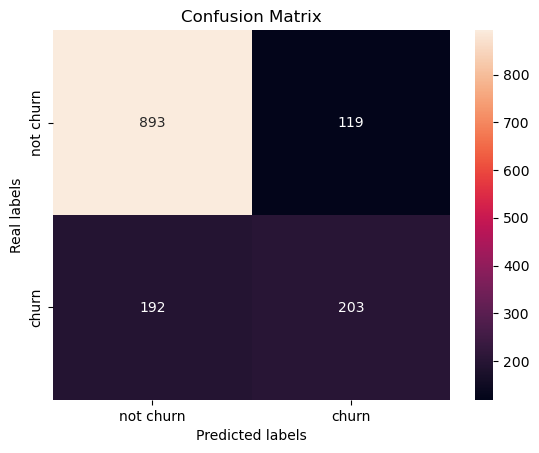

In [49]:
produce_confusion('churn', 'not churn', 'binary', predictions, 'pred', 'real')

apr(predictions['pred'], y_test)

# Selection and Application of Model

For the purpose of giving the customers likely to churn a False Negative has a larger downside than a False positive.

We therefore will select logistic regression as it has the highest accuracy and a much higher recall than the other models

#### Application of Logistic Regression Model to the dataset

In [50]:
### Redefine a cleaning and feature engineering function for our dataset
## Include useful results columns - Customer ID and other customer information

def feature_eng_result(df):

    ## TOTAL CHARGES:
    ## Convert Data Type Total Charges str to float ##
    df['Total Charges'] = pd.to_numeric(df['Total Charges'],errors='coerce')
    #### Drop Nulls from Total Charges ####
    df = df.dropna(axis=0, subset=['Total Charges'])

    ## CONVERTING COLUMNS INTO BOOLS:
    bools = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing' ]
    for x in bools:
        df[x] = df[x].map({'No': 0, 'Yes':1})
    ## Convert Gender column into Bools ##
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

    df_eng = df.copy()

    #ONE HOT ENCODING:

    eng_columns = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup',
                   'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
                   'Contract', 'Payment Method']

    df_eng = pd.get_dummies(df_eng, columns = eng_columns, drop_first=True)

    ### Log features ###

    df_eng['Log Tenure Months'] = np.log(df_eng['Tenure Months'])

    return df_eng

In [51]:
## Apply predictions to the entire dataframe

df_result = df.copy()
df_result = feature_eng_result(df_result)
df_result[['prob_stay', 'prob_churned']] = lr.predict_proba(df_result[mod_cols])




In [52]:
## List of customers by probability of churn!

pchurn_customers = df_result.groupby('CustomerID')[['prob_churned']].sum().sort_values(by = 'prob_churned', ascending = False)
pchurn_customers = pchurn_customers.rename(columns = {'prob_churned':'Churn Probability'})
pchurn_customers.reset_index(inplace=True)

print(pchurn_customers)

      CustomerID  Churn Probability
0     7216-EWTRS           0.949496
1     5178-LMXOP           0.948658
2     4826-XTSOH           0.948658
3     8775-LHDJH           0.946655
4     1415-YFWLT           0.936067
...          ...                ...
7027  6253-GNHWH           0.004566
7028  9114-DPSIA           0.004489
7029  0531-XBKMM           0.004421
7030  4632-XJMEX           0.004360
7031  8597-CTXVJ           0.004239

[7032 rows x 2 columns]


In [53]:
### Top 500 List of customers most likely to churn
pchurn_customers.head(500)

,CustomerID,Churn Probability
0,7216-EWTRS,0.949496
1,5178-LMXOP,0.948658
2,4826-XTSOH,0.948658
3,8775-LHDJH,0.946655
4,1415-YFWLT,0.936067
...,...,...
495,1184-PJVDB,0.732825
496,7249-WBIYX,0.732825
497,8622-ZLFKO,0.732741
498,2660-EMUBI,0.732518


In [54]:
## Export list to Excel
##pchurn_customers.to_excel('Customer_Churn_Probability.xlsx')